In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
!unzip 'drive/MyDrive/COMP3710/OASIS.zip' -d 'sample_data/data/'

In [2]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision import datasets, transforms
import pickle as pkl

In [45]:
dataroot = f'sample_data/data'
nc=1
b_size=32
dataset=datasets.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.Resize([64,64]) #[image_size,image_size]->resize H and W, image_size->resize W
        ,transforms.ToTensor()
        ,transforms.Grayscale(1) #reduce the channel number to 1 to make the calculation faster
        ,transforms.Normalize(0.5,0.5) #rescale the range of input values to -1~1(from 0~1)
        ]))

In [46]:
dataloader=DataLoader(dataset,num_workers=0,batch_size=b_size,shuffle=True)

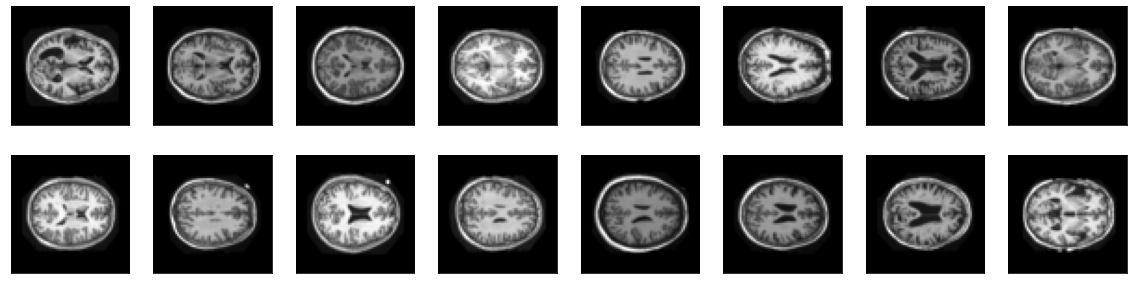

In [47]:
dataiter=iter(dataloader)
images,labels=dataiter.next()

def Gshow(img): #show gray scale images
  img_=img.numpy()
  img_=img.reshape(img_.shape[1],img_.shape[2]) #reshape from 64*64*1 to 64*64 as imshow(cmap='gray) only takes two values
  plt.imshow(img_,cmap='gray')# 64*64

plot_only=16 #plot only 16 images
fig=plt.figure(1,figsize=(20,5))
for idx in range(plot_only):
  ax=fig.add_subplot(2,plot_only/2,idx+1,xticks=[],yticks=[])
  Gshow(images[idx])